In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
os.chdir(r"C:\Users\Gram\Desktop\스배데\데이콘 상점 신용카드 매출 예측 경진대회\data")
df = pd.read_csv('funda_train.csv')

In [3]:
df.store_id = df.store_id.astype(np.int32)
df.card_id = df.card_id.astype(np.int32)
df.card_company = df.card_company.astype('category') 
df.transacted_date = pd.to_datetime(df.transacted_date + " " + df.transacted_time, format='%Y-%m-%d %H:%M')
df.installment_term = df.installment_term.astype(np.int16)
df.region = df.region.astype('category')
df.type_of_business = df.type_of_business.astype('category')

del df['transacted_time']  

In [4]:
df.head()

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01 13:13:00,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01 18:12:00,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01 18:52:00,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01 20:22:00,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02 11:06:00,0,NaN,기타 미용업,2000.000000


# 1. 분석적 관점에서 모델링
- 가설을 통한 모델링

## 1.1 가설 1 시간에 따른 매출 변동이 얼마나 클까?
- 어떤 상점은 2016년부터 매출이 발생하고, 어떤 상점은 2018년부터 매출이 발생
- 어떤 상점은 데이터가 거의 없을 수도 있음
- 어떤 상점은 폐업, 휴점했을 수도 있음


### 1.1.1 각 상점 별로 데이터가 존재하는 기간

In [5]:
# 상점 별 데이터가 존재 기간 = 기간의 최대 - 기간의 최소
store_period = df.groupby('store_id').transacted_date.max() - df.groupby('store_id').transacted_date.min()
store_period

store_id
0      1002 days 05:46:00
1      1002 days 02:46:00
2       989 days 01:03:00
4      1002 days 02:37:00
5      1002 days 04:34:00
              ...        
2132    919 days 06:23:00
2133    992 days 21:48:00
2134    840 days 07:59:00
2135    932 days 02:56:00
2136    647 days 06:23:00
Name: transacted_date, Length: 1967, dtype: timedelta64[ns]

In [6]:
# 깔끔하게 보기 위해 reset_index
store_period = (df.groupby('store_id').transacted_date.max() - df.groupby('store_id').transacted_date.min()).reset_index(name='period')
store_period

,store_id,period
0,0,1002 days 05:46:00
1,1,1002 days 02:46:00
2,2,989 days 01:03:00
3,4,1002 days 02:37:00
4,5,1002 days 04:34:00
...,...,...
1962,2132,919 days 06:23:00
1963,2133,992 days 21:48:00
1964,2134,840 days 07:59:00
1965,2135,932 days 02:56:00


In [7]:
import matplotlib.pyplot as plt  # 옵션을 주기 위해 plt를 사용

plt.hist(store_period.period.dt.days)
plt.title('data exist period')
plt.xlabel('days')
plt.show()

# 대부분 상점들의 데이터 존재 기간이 1000일 정도
# 일부 상점의 경우 600,700일 존재

<Figure size 640x480 with 1 Axes>

In [8]:
# 히스토그램으로 데이터가 작은 부분은 잘 보이지 않아 직접 확인
store_period.period.dt.days.nsmallest(10)
# 1950번 상점은 데이터가 340개 뿐

1950    340
1887    583
937     617
1189    638
1434    639
641     640
1796    640
1370    642
1864    642
655     643
Name: period, dtype: int64

### 상점 1개를 샘플로 확인

In [9]:
df[df.store_id ==2119]
# 2017~2018년까지 데이터가 있고, 2018년 이후 데이터가 없음 
# 이 경우에는 이후 3개월간 매출도 없을 것 -> 폐점한 것으로 보이는 케이스

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
6492743,2119,4629260,c,2017-03-23 14:45:00,0,NaN,NaN,275000.000000
6492744,2119,4629261,a,2017-03-27 11:31:00,0,NaN,NaN,114285.714286
6492745,2119,2171166,d,2017-03-27 11:58:00,0,NaN,NaN,148571.428571
6492746,2119,4629262,d,2017-03-28 11:13:00,0,NaN,NaN,78571.428571
6492747,2119,4629263,a,2017-03-28 11:19:00,0,NaN,NaN,112000.000000
...,...,...,...,...,...,...,...,...
6492850,2119,4629273,c,2018-02-12 13:34:00,0,NaN,NaN,60000.000000
6492851,2119,4629260,c,2018-02-20 12:16:00,0,NaN,NaN,296428.571429
6492852,2119,4629276,d,2018-02-20 15:33:00,0,NaN,NaN,110000.000000
6492853,2119,4629261,a,2018-02-26 13:22:00,0,NaN,NaN,122857.142857


### 최근에 생긴 상점의 데이터 존재 기간 확인
- 번호가 클 수록 최근에 생긴 상점일 수 있음
- 최신 데이터가 존재할 가능성이 있음

In [10]:
df.store_id.max()
# 2136이 제일 큰 상점번호

2136

In [11]:
df[df.store_id ==2136]
# 실제로 2017년부터 시작함

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
6547641,2136,4535759,d,2017-05-22 17:31:00,0,제주 제주시,기타 주점업,1857.142857
6547642,2136,4535759,d,2017-05-22 17:31:00,0,제주 제주시,기타 주점업,-1857.142857
6547643,2136,4535759,d,2017-05-22 17:42:00,0,제주 제주시,기타 주점업,9142.857143
6547644,2136,4535759,d,2017-05-22 17:42:00,0,제주 제주시,기타 주점업,-9142.857143
6547645,2136,4658439,c,2017-05-23 00:14:00,0,제주 제주시,기타 주점업,5000.000000
...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28 23:20:00,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28 23:27:00,0,제주 제주시,기타 주점업,571.428571



### 1.1.2 휴점을 오래하는 상점이 있는가? 데이터가 끊겼다가 다시 발생하는 게 흔한 것인가?

In [12]:
from tqdm import tqdm  # 작동 시간을 보여줌

In [13]:
# lambda는 유저 정의 함수를 간단히 사용하게끔
max_time_diff = lambda group: (group.store_id.values[0], group.transacted_date.diff().max()) # store_id도 반환하도록 함

In [14]:
from joblib import Parallel, delayed   # 멀티프로세싱 라이브러리(사이킷런에서 많이 씀)
res = Parallel(n_jobs=14)(delayed(max_time_diff)(group)  # 16개 코어 중 14개 사용
                         for _, group in tqdm(df.groupby('store_id'), total=df.store_id.nunique()))

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:38<00:00, 51.28it/s]


In [15]:
max_diff_df = pd.DataFrame(res, columns=['store_id', 'max_diff']) 
max_diff_df

,store_id,max_diff
0,0,6 days 15:49:00
1,1,10 days 19:35:00
2,2,36 days 19:32:00
3,4,3 days 17:32:00
4,5,8 days 20:06:00
...,...,...
1962,2132,3 days 23:52:00
1963,2133,53 days 17:13:00
1964,2134,85 days 00:48:00
1965,2135,8 days 21:54:00


In [16]:
max_diff_df.nlargest(10, 'max_diff')
# 795상점은 656일 휴무

,store_id,max_diff
742,795,656 days 21:07:00
1117,1204,554 days 17:15:00
590,632,518 days 14:52:00
251,271,492 days 01:49:00
1912,2081,485 days 02:40:00
1563,1696,462 days 19:57:00
1691,1836,386 days 02:41:00
469,506,317 days 20:46:00
1643,1783,306 days 17:02:00
1260,1364,288 days 01:58:00


In [17]:
import datetime
print(f"100일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: {(max_diff_df.max_diff>datetime.timedelta(days=100)).sum()}")
# 총 상점 수가 2000개 였는데 69개면 적지 않은 편

100일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 69


In [18]:
for days in (10, 50, 90, 150, 300):
    print(f"{days}일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: {(max_diff_df.max_diff>datetime.timedelta(days=days)).sum()}")
# 10일이상은 959개로 흔한 일
# 50일 이상도 159나 있으나 드문 일은 아님

10일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 959
50일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 159
90일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 83
150일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 36
300일 이상 기록이 없었다가 다시 로그가 생겨난 상점 수: 9


### 1.1.3 한 달 단위 상점 매출 확인

- 상당 수의 상점들이 풀로 데이터가 있고, 10일이상 쉬는 건 흔한 일
- 하루 단위로 매출량을 보면 진폭이 클 것 같아 한 달 단위로 매출량을 확인해보고자 함

In [19]:
sampled_stores = df.store_id.drop_duplicates().sample(5) 
sampled_stores

3631566    1196
2631361     866
5449858    1795
2950206     964
6031112    1980
Name: store_id, dtype: int32

In [20]:
sampled_df = df[df.store_id.isin(sampled_stores)]
sampled_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount
2631361,866,1841767,c,2016-06-01 12:07:00,5,충남 천안시,화장품 및 화장용품 도매업,71428.571429
2631362,866,1841768,f,2016-06-01 12:44:00,0,충남 천안시,화장품 및 화장용품 도매업,39285.714286
2631363,866,1841769,d,2016-06-01 17:51:00,0,충남 천안시,화장품 및 화장용품 도매업,1357.142857
2631364,866,1841770,c,2016-06-01 19:42:00,0,충남 천안시,화장품 및 화장용품 도매업,1571.428571
2631365,866,1841771,f,2016-06-02 11:18:00,0,충남 천안시,화장품 및 화장용품 도매업,19571.428571
...,...,...,...,...,...,...,...,...
6039277,1980,4292572,a,2019-02-28 14:16:00,0,NaN,NaN,1857.142857
6039278,1980,2453662,d,2019-02-28 15:09:00,0,NaN,NaN,1928.571429
6039279,1980,4292553,d,2019-02-28 18:45:00,0,NaN,NaN,16000.000000
6039280,1980,4292466,g,2019-02-28 19:05:00,0,NaN,NaN,857.142857


### 월기준 분류


In [21]:
sampled_df = sampled_df.assign(transacted_month = sampled_df.transacted_date.dt.month)
sampled_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
2631361,866,1841767,c,2016-06-01 12:07:00,5,충남 천안시,화장품 및 화장용품 도매업,71428.571429,6
2631362,866,1841768,f,2016-06-01 12:44:00,0,충남 천안시,화장품 및 화장용품 도매업,39285.714286,6
2631363,866,1841769,d,2016-06-01 17:51:00,0,충남 천안시,화장품 및 화장용품 도매업,1357.142857,6
2631364,866,1841770,c,2016-06-01 19:42:00,0,충남 천안시,화장품 및 화장용품 도매업,1571.428571,6
2631365,866,1841771,f,2016-06-02 11:18:00,0,충남 천안시,화장품 및 화장용품 도매업,19571.428571,6
...,...,...,...,...,...,...,...,...,...
6039277,1980,4292572,a,2019-02-28 14:16:00,0,NaN,NaN,1857.142857,2
6039278,1980,2453662,d,2019-02-28 15:09:00,0,NaN,NaN,1928.571429,2
6039279,1980,4292553,d,2019-02-28 18:45:00,0,NaN,NaN,16000.000000,2
6039280,1980,4292466,g,2019-02-28 19:05:00,0,NaN,NaN,857.142857,2


In [22]:
sampled_grouped = sampled_df.groupby(['store_id', 'transacted_month']).amount.sum().reset_index(name='amount')
sampled_grouped
# 생각해보니 월 별로 하면 3년치라 월이 많이 반복됨

,store_id,transacted_month,amount
0,866,1,2.196186e+06
1,866,2,1.983286e+06
2,866,3,2.042557e+06
3,866,4,1.667214e+06
4,866,5,1.508757e+06
5,866,6,2.501971e+06
6,866,7,1.785700e+06
7,866,8,2.126214e+06
8,866,9,1.981214e+06
9,866,10,1.836500e+06


### 년도+월기준 분류

In [23]:
sampled_df.transacted_date.dt.to_period("M")

2631361    2016-06
2631362    2016-06
2631363    2016-06
2631364    2016-06
2631365    2016-06
            ...   
6039277    2019-02
6039278    2019-02
6039279    2019-02
6039280    2019-02
6039281    2019-02
Name: transacted_date, Length: 27330, dtype: period[M]

In [24]:
sampled_df =  sampled_df.assign(transacted_month = sampled_df.transacted_date.dt.to_period("M"))
sampled_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
2631361,866,1841767,c,2016-06-01 12:07:00,5,충남 천안시,화장품 및 화장용품 도매업,71428.571429,2016-06
2631362,866,1841768,f,2016-06-01 12:44:00,0,충남 천안시,화장품 및 화장용품 도매업,39285.714286,2016-06
2631363,866,1841769,d,2016-06-01 17:51:00,0,충남 천안시,화장품 및 화장용품 도매업,1357.142857,2016-06
2631364,866,1841770,c,2016-06-01 19:42:00,0,충남 천안시,화장품 및 화장용품 도매업,1571.428571,2016-06
2631365,866,1841771,f,2016-06-02 11:18:00,0,충남 천안시,화장품 및 화장용품 도매업,19571.428571,2016-06
...,...,...,...,...,...,...,...,...,...
6039277,1980,4292572,a,2019-02-28 14:16:00,0,NaN,NaN,1857.142857,2019-02
6039278,1980,2453662,d,2019-02-28 15:09:00,0,NaN,NaN,1928.571429,2019-02
6039279,1980,4292553,d,2019-02-28 18:45:00,0,NaN,NaN,16000.000000,2019-02
6039280,1980,4292466,g,2019-02-28 19:05:00,0,NaN,NaN,857.142857,2019-02


In [25]:
sampled_grouped = sampled_df.groupby(['store_id', 'transacted_month']).amount.sum().reset_index(name='amount')
sampled_grouped

,store_id,transacted_month,amount
0,866,2016-06,631114.285714
1,866,2016-07,553214.285714
2,866,2016-08,733071.428571
3,866,2016-09,520500.000000
4,866,2016-10,454000.000000
...,...,...,...
142,1980,2018-10,978928.571429
143,1980,2018-11,798542.857143
144,1980,2018-12,595214.285714
145,1980,2019-01,819714.285714


## 1.2 가설 2 type of business 별로 판매액이 다른가?


### 1.2.1 업종별 판매량 평균

In [26]:
df = df.assign(transacted_month = df.transacted_date.dt.to_period("M").dt.to_timestamp())
df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
0,0,0,b,2016-06-01 13:13:00,0,NaN,기타 미용업,1857.142857,2016-06-01
1,0,1,h,2016-06-01 18:12:00,0,NaN,기타 미용업,857.142857,2016-06-01
2,0,2,c,2016-06-01 18:52:00,0,NaN,기타 미용업,2000.000000,2016-06-01
3,0,3,a,2016-06-01 20:22:00,0,NaN,기타 미용업,7857.142857,2016-06-01
4,0,4,c,2016-06-02 11:06:00,0,NaN,기타 미용업,2000.000000,2016-06-01
...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28 23:20:00,0,제주 제주시,기타 주점업,-4500.000000,2019-02-01
6556609,2136,4663855,d,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4142.857143,2019-02-01
6556610,2136,4663489,a,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4500.000000,2019-02-01
6556611,2136,4663856,d,2019-02-28 23:27:00,0,제주 제주시,기타 주점업,571.428571,2019-02-01


In [27]:
# 판매량의 합
business_group = df.groupby(['store_id', 'transacted_month']).amount.sum().dropna().reset_index(name='amount') 
business_group

,store_id,transacted_month,amount
0,0,2016-06-01,7.470000e+05
1,0,2016-07-01,1.005000e+06
2,0,2016-08-01,8.715714e+05
3,0,2016-09-01,8.978571e+05
4,0,2016-10-01,8.354286e+05
...,...,...,...
60227,2136,2018-10-01,2.012214e+06
60228,2136,2018-11-01,2.135429e+06
60229,2136,2018-12-01,2.427429e+06
60230,2136,2019-01-01,1.873643e+06


In [28]:
# 판매량의 합을 구한 후 판매량의 평균을 구함
business_group = business_group.groupby('store_id').amount.mean().reset_index(name='amount') 
business_group

,store_id,amount
0,0,7.325597e+05
1,1,1.111710e+05
2,2,2.679697e+05
3,4,9.060896e+05
4,5,3.291407e+05
...,...,...
1962,2132,7.301258e+05
1963,2133,3.450049e+05
1964,2134,3.133654e+05
1965,2135,5.853940e+05


In [29]:
business_group = business_group.merge(df[['store_id', 'type_of_business']].drop_duplicates().dropna(), on='store_id')
business_group

,store_id,amount,type_of_business
0,0,7.325597e+05,기타 미용업
1,5,3.291407e+05,의복 액세서리 및 모조 장신구 도매업
2,8,9.574663e+05,한식 음식점업
3,12,2.498499e+05,배관 및 냉ㆍ난방장치 도매업
4,14,3.638710e+06,그 외 기타 스포츠시설 운영업
...,...,...,...
787,2125,2.532578e+06,한식 음식점업
788,2126,1.104377e+05,간이음식 포장 판매 전문점
789,2128,5.319870e+05,의복 소매업
790,2130,8.711861e+04,비알코올 음료점업


In [30]:
business_group_amount = business_group.groupby('type_of_business').amount.mean()
business_group_amount

type_of_business
가구 소매업               2.250893e+06
가전제품 소매업             2.271011e+06
가정용 세탁업              3.585084e+05
가정용 직물제품 소매업         1.405862e+06
간이음식 포장 판매 전문점       7.165532e+05
                         ...     
한의원                  6.470462e+05
화장품 및 화장용품 도매업       1.606644e+06
화장품, 비누 및 방향제 소매업    8.375633e+05
화초 및 식물 소매업          4.889491e+05
화훼류 및 식물 도매업         9.074083e+05
Name: amount, Length: 145, dtype: float64

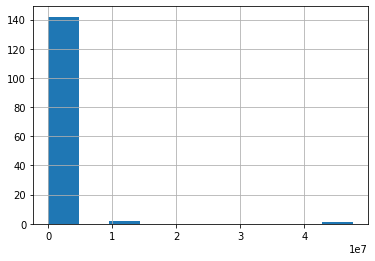

In [31]:
business_group.groupby('type_of_business').amount.mean().hist()
# 일부 상점들이 대부분을 차지함

### 부동소수점 표시 변환

In [32]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [33]:
business_group_amount = business_group_amount.reset_index(name='amount')

In [34]:
business_group_amount.nlargest(10, 'amount')
# 의약품이 많이 팔림

,type_of_business,amount
101,의약품 도매업,47531520.03
106,일반 병원,10937807.79
36,기타 산업용 농산물 도매업,9665114.72
83,안경 및 안경렌즈 제조업,4249680.09
69,속옷 및 잠옷 소매업,3902221.21
64,상품 종합 도매업,3605705.85
135,"페인트, 창호 및 기타 건설자재 소매업",3507135.93
9,경영 컨설팅업,3398826.02
87,여행사업,2759418.17
70,수산물 가공식품 도매업,2731020.76


### 1.2.2 업종별로 상점이 몇가지 있는가?


In [35]:
business_group_amount = (
    business_group_amount.merge(
        df.groupby('type_of_business').store_id.nunique().reset_index(name='store_count')
        , on='type_of_business')
)

In [36]:
business_group_amount.nlargest(10, 'amount')
# 의약품도매업이 1개 밖에 없는데 차지하는 양이 큼 -> 산업군 특성일 듯

,type_of_business,amount,store_count
101,의약품 도매업,47531520.03,1
106,일반 병원,10937807.79,1
36,기타 산업용 농산물 도매업,9665114.72,1
83,안경 및 안경렌즈 제조업,4249680.09,1
69,속옷 및 잠옷 소매업,3902221.21,1
64,상품 종합 도매업,3605705.85,2
135,"페인트, 창호 및 기타 건설자재 소매업",3507135.93,1
9,경영 컨설팅업,3398826.02,1
87,여행사업,2759418.17,2
70,수산물 가공식품 도매업,2731020.76,1


# 2. train test split
- 현재 데이터는 train과 test로 나눠져있지 않음
- 최근 3개월을 test로 정의

In [37]:
import datetime
train_df = df[df.transacted_date < datetime.date(2018, 12, 1)]     # train : ~ 201811
test_df = df[~(df.transacted_date < datetime.date(2018, 12, 1))]   # test : 201902, 201901, 201812

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
train_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
0,0,0,b,2016-06-01 13:13:00,0,NaN,기타 미용업,1857.14,2016-06-01
1,0,1,h,2016-06-01 18:12:00,0,NaN,기타 미용업,857.14,2016-06-01
2,0,2,c,2016-06-01 18:52:00,0,NaN,기타 미용업,2000.00,2016-06-01
3,0,3,a,2016-06-01 20:22:00,0,NaN,기타 미용업,7857.14,2016-06-01
4,0,4,c,2016-06-02 11:06:00,0,NaN,기타 미용업,2000.00,2016-06-01
...,...,...,...,...,...,...,...,...,...
6555532,2136,4662879,e,2018-11-30 23:29:00,0,제주 제주시,기타 주점업,4000.00,2018-11-01
6555533,2136,4663221,d,2018-11-30 23:42:00,0,제주 제주시,기타 주점업,5428.57,2018-11-01
6555534,2136,4663222,d,2018-11-30 23:44:00,0,제주 제주시,기타 주점업,3714.29,2018-11-01
6555535,2136,4663223,b,2018-11-30 23:50:00,0,제주 제주시,기타 주점업,5142.86,2018-11-01


In [39]:
test_df

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
4099,0,1677,f,2018-12-01 12:13:00,0,NaN,기타 미용업,7142.86,2018-12-01
4100,0,1416,c,2018-12-01 13:34:00,0,NaN,기타 미용업,2000.00,2018-12-01
4101,0,1678,b,2018-12-01 14:04:00,0,NaN,기타 미용업,2000.00,2018-12-01
4102,0,1679,b,2018-12-01 14:20:00,0,NaN,기타 미용업,2000.00,2018-12-01
4103,0,1644,a,2018-12-01 15:43:00,0,NaN,기타 미용업,1857.14,2018-12-01
...,...,...,...,...,...,...,...,...,...
6556608,2136,4663855,d,2019-02-28 23:20:00,0,제주 제주시,기타 주점업,-4500.00,2019-02-01
6556609,2136,4663855,d,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4142.86,2019-02-01
6556610,2136,4663489,a,2019-02-28 23:24:00,0,제주 제주시,기타 주점업,4500.00,2019-02-01
6556611,2136,4663856,d,2019-02-28 23:27:00,0,제주 제주시,기타 주점업,571.43,2019-02-01


# 3. feature engineering
- feature1 : 최근 1개월
- feature2 : type_of_business
- feature3 : 평균 할부 개월수
- feature4 : 최빈 카드사(상점별로 여러 카드사가 있으니 최빈 카드사로)
- card_id는 개인 식별이라 제외

## 3.1 feature 1 : 최근 1개월

### 최근 1개월 추출

In [40]:
recent_df = train_df[train_df.transacted_date >= datetime.datetime(2018, 11, 1)]
recent_df
# train에서 최근 1개월은 201811

,store_id,card_id,card_company,transacted_date,installment_term,region,type_of_business,amount,transacted_month
3979,0,1585,f,2018-11-01 19:06:00,0,NaN,기타 미용업,2000.00,2018-11-01
3980,0,722,c,2018-11-02 10:53:00,0,NaN,기타 미용업,2000.00,2018-11-01
3981,0,1642,c,2018-11-03 13:19:00,0,NaN,기타 미용업,7142.86,2018-11-01
3982,0,1341,b,2018-11-03 13:20:00,0,NaN,기타 미용업,17142.86,2018-11-01
3983,0,1396,g,2018-11-03 14:12:00,0,NaN,기타 미용업,428.57,2018-11-01
...,...,...,...,...,...,...,...,...,...
6555532,2136,4662879,e,2018-11-30 23:29:00,0,제주 제주시,기타 주점업,4000.00,2018-11-01
6555533,2136,4663221,d,2018-11-30 23:42:00,0,제주 제주시,기타 주점업,5428.57,2018-11-01
6555534,2136,4663222,d,2018-11-30 23:44:00,0,제주 제주시,기타 주점업,3714.29,2018-11-01
6555535,2136,4663223,b,2018-11-30 23:50:00,0,제주 제주시,기타 주점업,5142.86,2018-11-01


### 최근 1개월 간 상점별 판매량 합

In [41]:
recent_amount = recent_df.groupby(['store_id']).amount.sum().reset_index(name='amount').dropna()  # amount에 NaN이 있을 수 있어 dropna
recent_amount

,store_id,amount
0,0,676000.00
1,1,80785.71
2,2,185428.57
3,4,883000.00
4,5,383300.00
...,...,...
1935,2132,729857.14
1936,2133,84714.29
1937,2134,60785.71
1938,2135,589428.57


## 3.2 feature 2 : type_of_business

In [42]:
store_business_type = train_df[['store_id', 'type_of_business']].drop_duplicates().dropna() # amount에 NaN이 있을 수 있어 dropna
store_business_type

,store_id,type_of_business
0,0,기타 미용업
14677,5,의복 액세서리 및 모조 장신구 도매업
26837,8,한식 음식점업
37584,12,배관 및 냉ㆍ난방장치 도매업
42528,14,그 외 기타 스포츠시설 운영업
...,...,...
6505557,2125,한식 음식점업
6514524,2126,간이음식 포장 판매 전문점
6519952,2128,의복 소매업
6526704,2130,비알코올 음료점업


## 3.3 feature3 : 평균 할부 개월 수

In [43]:
installment = train_df.groupby('store_id').installment_term.mean().reset_index(name='installment')
installment

,store_id,installment
0,0,0.11
1,1,0.00
2,2,0.22
3,4,0.04
4,5,0.20
...,...,...
1962,2132,0.00
1963,2133,0.08
1964,2134,0.01
1965,2135,0.00


## 3.4 feature4 :  최빈 카드사

In [44]:
store_most_card = train_df.groupby('store_id')['card_company'].agg(pd.Series.mode).reset_index(name='card_company')
store_most_card 
# 최빈값이 여러 개일 경우 중복이 있을 수 있음

,store_id,level_1,card_company
0,0,0,a
1,1,0,a
2,2,0,a
3,4,0,a
4,5,0,b
...,...,...,...
1969,2132,0,a
1970,2133,0,a
1971,2134,0,d
1972,2135,0,a


In [45]:
store_most_card = store_most_card.drop_duplicates('store_id')
store_most_card

,store_id,level_1,card_company
0,0,0,a
1,1,0,a
2,2,0,a
3,4,0,a
4,5,0,b
...,...,...,...
1969,2132,0,a
1970,2133,0,a
1971,2134,0,d
1972,2135,0,a


In [46]:
del store_most_card['level_1'] 
store_most_card 
# 모르는 열이 추가되 삭제

,store_id,card_company
0,0,a
1,1,a
2,2,a
3,4,a
4,5,b
...,...,...
1969,2132,a
1970,2133,a
1971,2134,d
1972,2135,a


## 3.5 튜닝된 피처 확인

In [47]:
recent_amount

,store_id,amount
0,0,676000.00
1,1,80785.71
2,2,185428.57
3,4,883000.00
4,5,383300.00
...,...,...
1935,2132,729857.14
1936,2133,84714.29
1937,2134,60785.71
1938,2135,589428.57


In [48]:
store_business_type

,store_id,type_of_business
0,0,기타 미용업
14677,5,의복 액세서리 및 모조 장신구 도매업
26837,8,한식 음식점업
37584,12,배관 및 냉ㆍ난방장치 도매업
42528,14,그 외 기타 스포츠시설 운영업
...,...,...
6505557,2125,한식 음식점업
6514524,2126,간이음식 포장 판매 전문점
6519952,2128,의복 소매업
6526704,2130,비알코올 음료점업


In [49]:
installment

,store_id,installment
0,0,0.11
1,1,0.00
2,2,0.22
3,4,0.04
4,5,0.20
...,...,...
1962,2132,0.00
1963,2133,0.08
1964,2134,0.01
1965,2135,0.00


In [50]:
store_most_card

,store_id,card_company
0,0,a
1,1,a
2,2,a
3,4,a
4,5,b
...,...,...
1969,2132,a
1970,2133,a
1971,2134,d
1972,2135,a


## 3.6 선택된 피처4개 병합

In [51]:
train_feature = (
    recent_amount.merge(
        store_business_type, on='store_id', how='outer')
    .merge(
        installment, on='store_id', how='outer')
    .merge(
        store_most_card, on='store_id', how='outer')
)

train_feature

,store_id,amount,type_of_business,installment,card_company
0,0,676000.00,기타 미용업,0.11,a
1,1,80785.71,NaN,0.00,a
2,2,185428.57,NaN,0.22,a
3,4,883000.00,NaN,0.04,a
4,5,383300.00,의복 액세서리 및 모조 장신구 도매업,0.20,b
...,...,...,...,...,...
1962,1466,nan,NaN,0.04,a
1963,1556,nan,NaN,0.06,a
1964,1935,nan,NaN,0.00,a
1965,2058,nan,NaN,0.00,c


## 3.7 fillna

In [52]:
# amount가 없는 것은 0으로 찍어줌
train_feature.amount = train_feature.amount.fillna(0)

In [53]:
# 유형이 없는 것은 없다는 뜻으로 missing으로 출력
train_feature.type_of_business = train_feature.type_of_business.astype('object').fillna('missing')

In [54]:
train_feature
# 결측값 채워진 것 확인

,store_id,amount,type_of_business,installment,card_company
0,0,676000.00,기타 미용업,0.11,a
1,1,80785.71,missing,0.00,a
2,2,185428.57,missing,0.22,a
3,4,883000.00,missing,0.04,a
4,5,383300.00,의복 액세서리 및 모조 장신구 도매업,0.20,b
...,...,...,...,...,...
1962,1466,0.00,missing,0.04,a
1963,1556,0.00,missing,0.06,a
1964,1935,0.00,missing,0.00,a
1965,2058,0.00,missing,0.00,c


## 3.8 원핫인코딩


In [55]:
# 더미할 거 2개밖에 없음
train_dummy = pd.concat([
    pd.get_dummies(train_feature.type_of_business, prefix='type_of_business'),
    pd.get_dummies(train_feature.card_company, prefix='card_company')
], axis=1)

train_dummy

,type_of_business_missing,type_of_business_가구 소매업,type_of_business_가전제품 소매업,type_of_business_가정용 세탁업,type_of_business_가정용 직물제품 소매업,type_of_business_간이음식 포장 판매 전문점,type_of_business_간판 및 광고물 제조업,type_of_business_건강보조식품 소매업,"type_of_business_게임용구, 인형 및 장난감 소매업",type_of_business_결혼 상담 및 준비 서비스업,...,type_of_business_화초 및 식물 소매업,type_of_business_화훼류 및 식물 도매업,card_company_a,card_company_b,card_company_c,card_company_d,card_company_e,card_company_f,card_company_g,card_company_h
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1963,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1964,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1965,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## 3.9 X값 설정
- 피처 4개 병합한 것 + 원핫인코딩한 피처

In [56]:
X = pd.concat([train_dummy, train_feature[['store_id', 'amount', 'installment']]], axis=1)
X

,type_of_business_missing,type_of_business_가구 소매업,type_of_business_가전제품 소매업,type_of_business_가정용 세탁업,type_of_business_가정용 직물제품 소매업,type_of_business_간이음식 포장 판매 전문점,type_of_business_간판 및 광고물 제조업,type_of_business_건강보조식품 소매업,"type_of_business_게임용구, 인형 및 장난감 소매업",type_of_business_결혼 상담 및 준비 서비스업,...,card_company_b,card_company_c,card_company_d,card_company_e,card_company_f,card_company_g,card_company_h,store_id,amount,installment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,676000.00,0.11
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,80785.71,0.00
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,185428.57,0.22
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,883000.00,0.04
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,5,383300.00,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1466,0.00,0.04
1963,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1556,0.00,0.06
1964,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1935,0.00,0.00
1965,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2058,0.00,0.00


## 3.10 y값 설정

In [57]:
y = test_df.groupby('store_id').amount.sum()
y

store_id
0      2072714.29
1       311000.00
2      1245428.57
4      2751000.00
5       938085.71
          ...    
2132   1675857.14
2133    200285.71
2134    379714.29
2135   1408428.57
2136   6528500.00
Name: amount, Length: 1950, dtype: float64

In [58]:
X.shape

(1967, 157)

In [59]:
y.shape

(1950,)

## 3.11 X와 y shape 맞춰줌

In [60]:
inter_store_id = set(X.store_id) & set(y.index)
# x와 y에 모두 존재하는 상점 아이디 가져옴

In [61]:
X = X[X.store_id.isin(inter_store_id)]
y = y[y.index.isin(inter_store_id)]

In [62]:
X = X.set_index('store_id')

In [63]:
X.shape

(1950, 156)

In [64]:
y.shape

(1950,)

# 4. 모델 학습/예측/평가
- 처음 만들 때 랜덤포레스트 많이 씀

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
clf = RandomForestRegressor(random_state=85)
clf.fit(X, y)

y_pred = pd.DataFrame(clf.predict(X), columns = ['amount']).assign(store_id = X.index)
y_pred

print(f"RF SCORE: {3662872.694785049:.2f}")
print(f"BASELINE SCORE: {821368.3424434928:.2f}")

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF SCORE: 3662872.69
BASELINE SCORE: 821368.34


In [66]:
os.chdir(r"C:\Users\Gram\Desktop\스배데\데이콘 상점 신용카드 매출 예측 경진대회\data")
submit = pd.read_csv("submission.csv")
submit = submit[['store_id']].merge(y_pred, on='store_id', how='left')
submit.amount = submit.amount.fillna(0)

In [67]:
submit.to_csv('random_forest.csv', index=False)